In [46]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path

# vizualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

# GIS
import fiona
import fiona.crs
import shapely
import rasterio
import rasterio.plot
import rasterio.mask
import geopandas as gpd

os.chdir("/home/lune/Code/ai4er/mres")
from src.loading import Load
import src.plots as plots
from src.mycolors import rand_cmap
from src.treechange import TreeChange,SegmentationRun
import src.utils as utils


In [36]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as fc

In [42]:
#%%
try:
    dirpath = Path(os.path.dirname(__file__))
except:
    dirpath = Path(os.getcwd())/"development_python"

# dir_data = Path(f"{dirpath}/../Data/lidar/danum")
dir_data = Path(f"{dirpath}/../Data/lidar/paracou")
os.getcwd()

'/home/lune/Code/ai4er/mres'

In [47]:
#%%

tc =TreeChange(dir_data,(2016,2019))
tc.gather_all_runs()
tc.load_rasters(create_diff=True)

Index of runs computed.


In [67]:
# #%%


# thold = 34
# counts = rn.df["diff_img"].apply(lambda x: np.sum(x.flatten()>thold))

<ipython-input-68-49f323522226>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


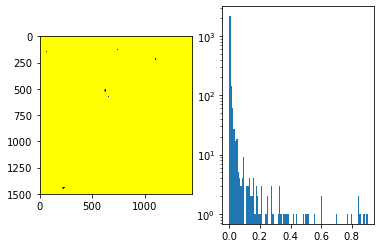

In [68]:
# #%%
# fig,ax = plt.subplots(ncols=2)
# colmap = plots.color_mapping_diff
# arr=np.ma.masked_less_equal(tc._diff_arr,thold)
# arr=arr[:arr.shape[0]//2,:arr.shape[1]//2]
# cmap = colmap.cmap
# cmap.set_bad('yellow')
# ax[0].imshow(arr,cmap=cmap, norm = colmap.norm)
# ax[1].hist(counts/rn.df['area']/4,100,log=True)
# fig.show()

In [5]:
%load_ext autoreload

In [6]:
%autoreload 2

In [7]:
 %matplotlib inline

In [10]:
import inspect
lines = inspect.getsource(SegmentationRun._missing_by_threshold)
print(lines)

    def _missing_by_threshold(self,threshold=None,keep_counts=True, pixel_ratio=0.2):
        if threshold is None:
            threshold=34
        def pixels_above_threshold(thresh):
            def func(arr):
                arr=arr.flatten()
                return np.sum(arr>thresh)
            return func

        counts = self.df["diff_img"].apply(pixels_above_threshold(threshold))
        is_missing=counts/(self.df["area"]*4) > pixel_ratio
        if keep_counts:
            self.df = self.df.assign(missing_pixels=counts)
        return is_missing



In [50]:
#%%
rn = tc.load_run_random(load_rast=[])
# rn=tc.load_run(319,load_rast=[])
# rn.find_missing_trees(pixel_ratio=0.1);

In [51]:
rn.print()

Parameters loaded:
	ws      16.000000
	seed     0.338502
	cr       0.547414
	max     53.670590
	Name: 1, dtype: float64
Dataframe:
	Polygon interiors: No
	Rows:	 20194
	Columns:	 6
		['geometry', 'area', 'nn', 'nn2', 'diff', 'i_diff']



In [52]:
extent_full = shapely.geometry.box(*tc.chm.old.bounds)
xmin,ymin,xmax,ymax =extent_full.bounds

AttributeError: 'GeoDataFrame' object has no attribute 'is_missing'

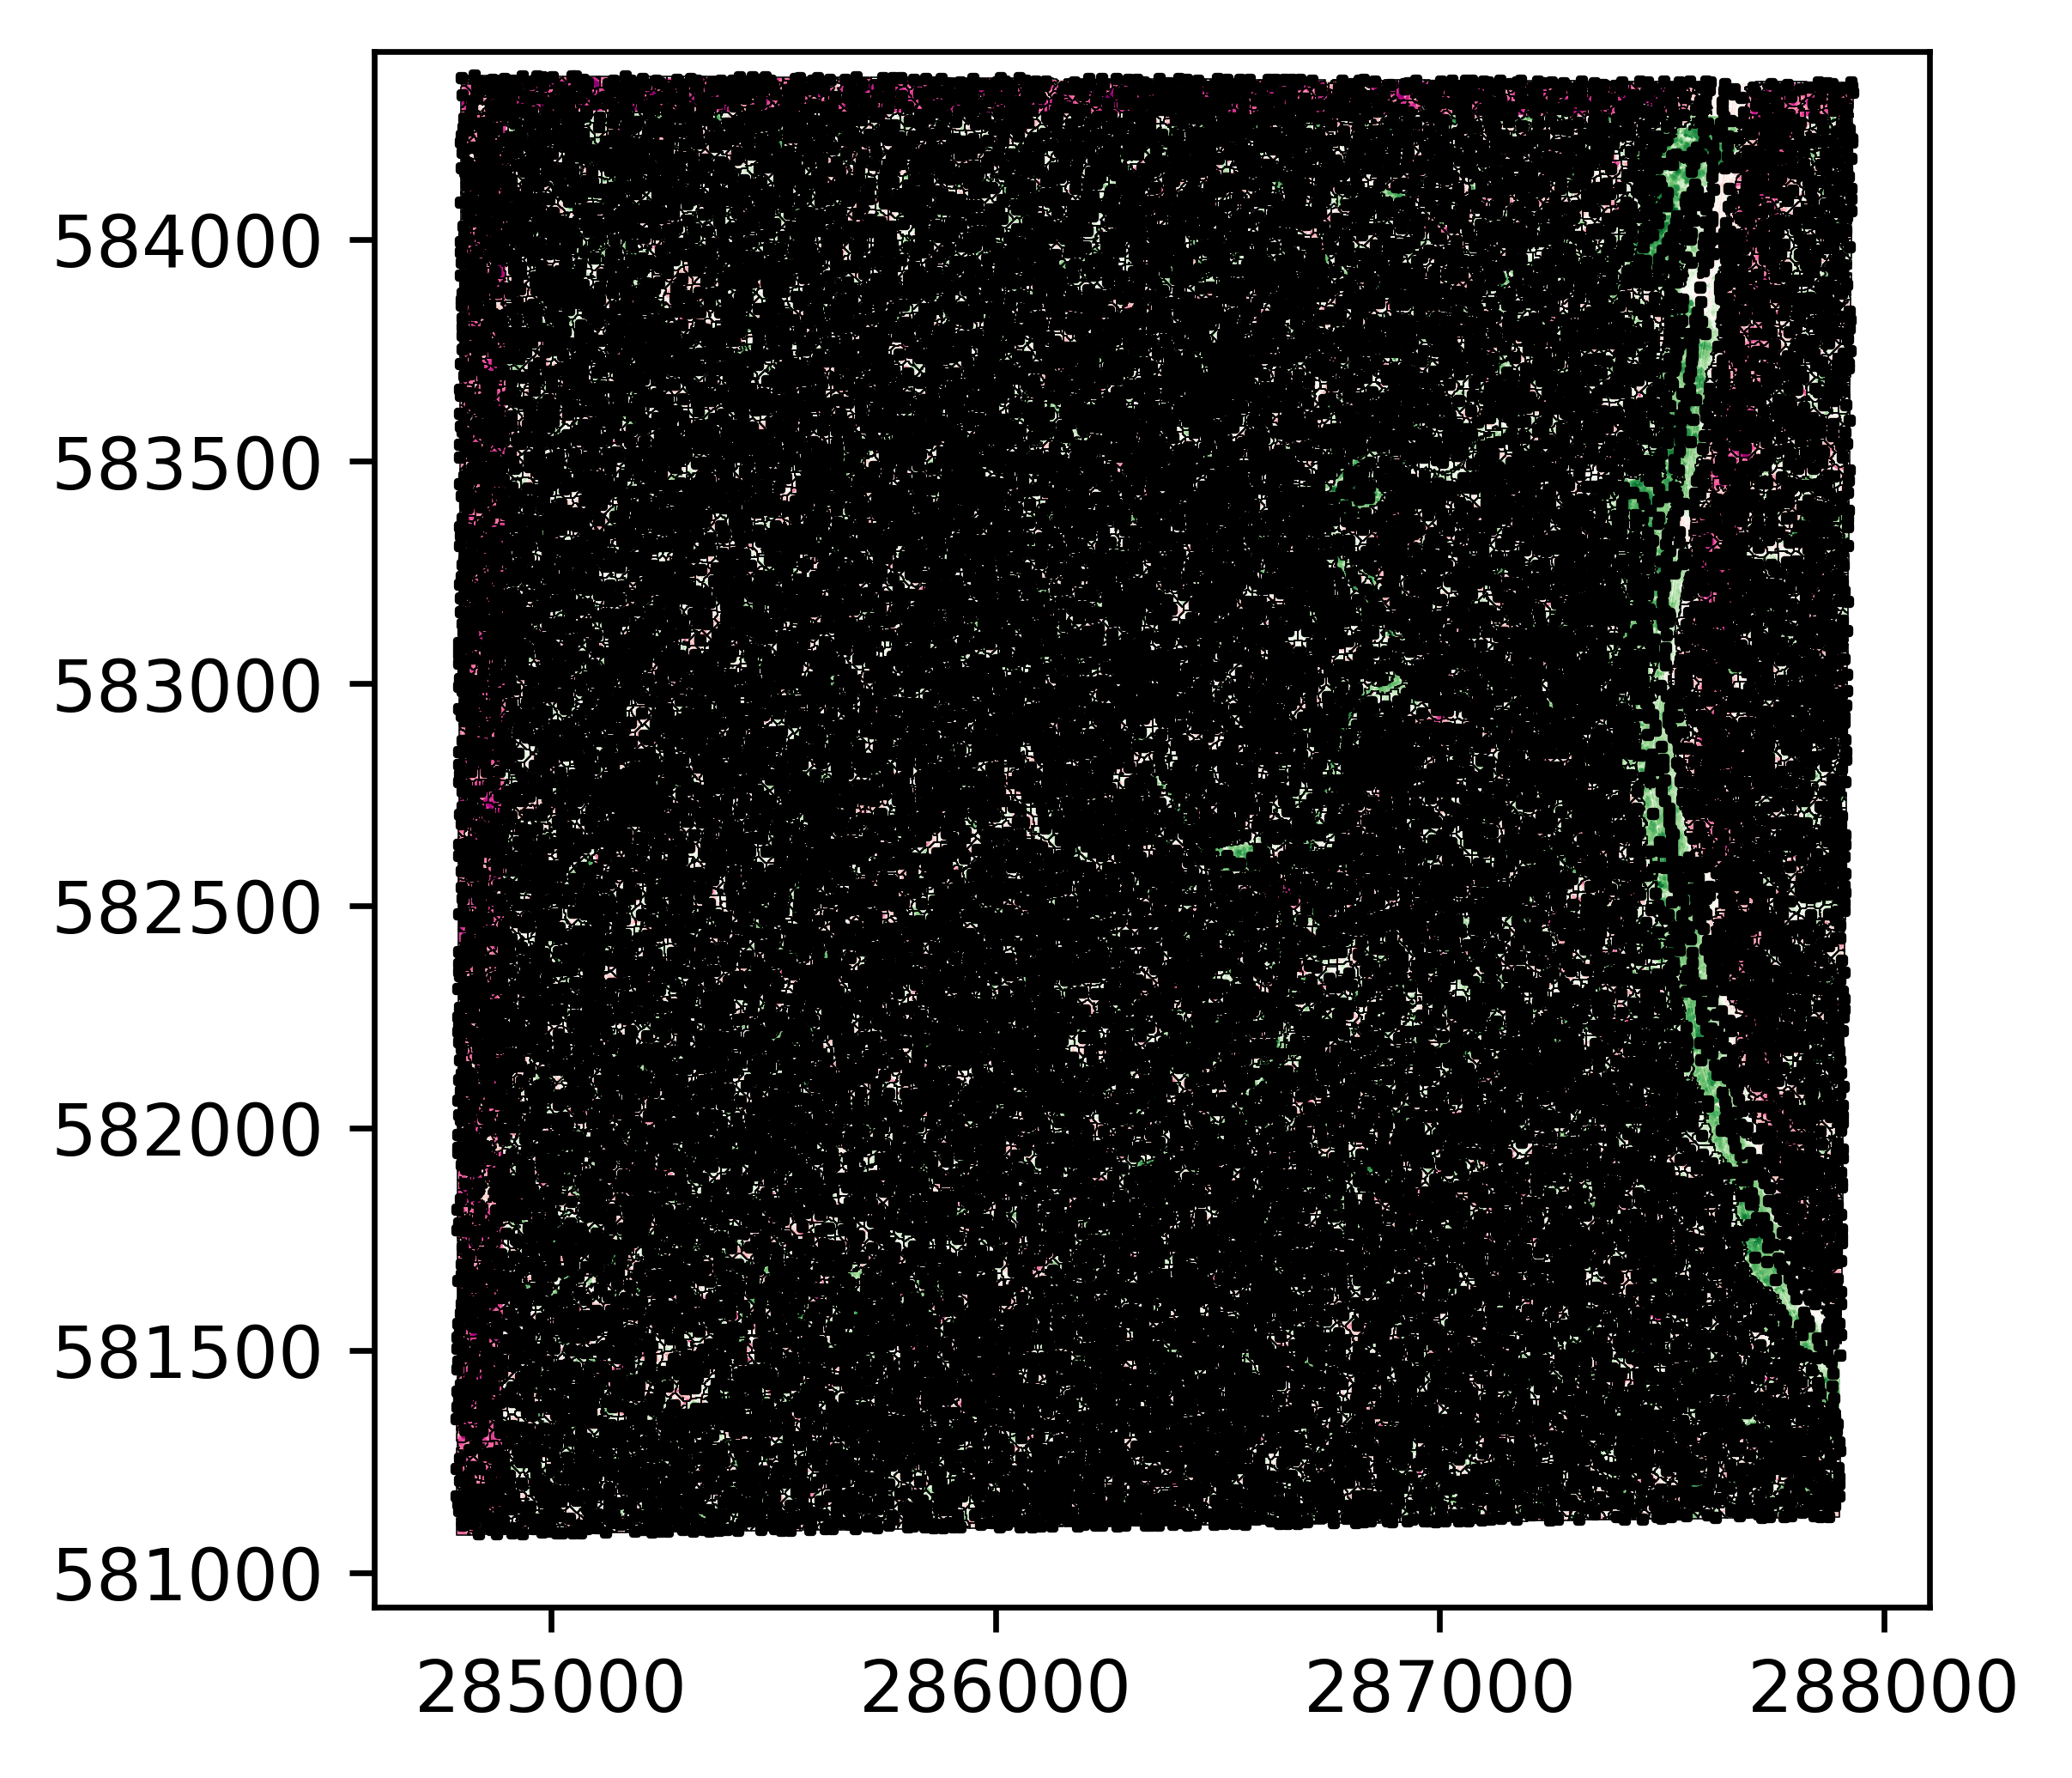

In [53]:
cropx = (0.0,0.3)
cropy = (0.8,1)
xmin,ymin,xmax,ymax =utils.crop(extent_full.bounds,(*cropx,*cropy))



fig,ax = plt.subplots(dpi=600)
colm=plots.color_mapping_diff
plots.plot_raster(tc.diff,ax=ax,cmap=colm.cmap,norm=colm.norm)

rn._tt.old.plot(marker=',',markersize=0.5,color='k',ax=ax)

polygon_par = dict()
rn.df.geometry.exterior.plot(ax=ax,color='k',
                                      linewidth=0.2,
                                      **polygon_par)
rn.df[rn.df.is_missing].exterior.plot(ax=ax,color='y',
                                      linewidth=1,
                                      **polygon_par)
# rn.df[np.logical_not(rn.df.is_missing)].exterior.plot(ax=ax,color='k',
#                                                       linewidth=0.3,
#                                                       **polygon_par)

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.axis("off")

In [24]:
area=extent_full.area/1000000

In [54]:
tc.print()


Tree Comparison Object
Data (dir_data):	/home/lune/Data/ai4er/mres/lidar/paracou
Years:	Pair(old=2016, new=2019)
Rasters:
	old: rasters/raster2016.tif
	new: rasters/raster2019.tif
	diff: rasters/diff.tif
Available runs:
	file: index.txt
	Number: 2
	WS: [16, 17]
	    [1, 1]
Runs loaded:
	Number: 1
	Run 1
		Parameters loaded:
			ws      16.000000
			seed     0.338502
			cr       0.547414
			max     53.670590
			Name: 1, dtype: float64
		Dataframe:
			Polygon interiors: No
			Rows:	 20194
			Columns:	 6
				['geometry', 'area', 'nn', 'nn2', 'diff', 'i_diff']



In [55]:
def gather_values(rn):
    s = pd.Series()
    s["misspx_10"] = rn.find_missing_trees(pixel_ratio=0.10).sum()
    s["missar_10"] = rn.df["area"][rn.df["is_missing"]].sum()
    s["misspx_15"] = rn.find_missing_trees(pixel_ratio=0.15).sum()
    s["missar_15"] = rn.df["area"][rn.df["is_missing"]].sum()
    s["misspx_20"] = rn.find_missing_trees(pixel_ratio=0.20).sum()
    s["missar_20"] = rn.df["area"][rn.df["is_missing"]].sum()
    s["total_trees"] = rn.df.shape[0]
    s["area_total"] = rn.df["area"].sum()
    s["area_mean"] = rn.df['area'].mean()
    s["area_median"] = rn.df['area'].median()
    return s

In [56]:
val = gather_values(rn)

<ipython-input-55-045c54375490>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()


In [57]:
print(f"'misspx_10': {val['misspx_10']/val['total_trees']}")
print(f"'misspx_15': {val['misspx_15']/val['total_trees']}")
print(f"'misspx_20': {val['misspx_20']/val['total_trees']}")
print(f"'total_trees': {val['total_trees']/area}")
print(f"'missar_10': {val['missar_10']/val['area_total']}")
print(f"'missar_15': {val['missar_15']/val['area_total']}")
print(f"'missar_20': {val['missar_20']/val['area_total']}")
print(f"'area_total': {val['area_total']/area}")
print(f"'area_mean': {val['area_mean']}")
print(f"'area_median': {val['area_median']}")



'misspx_10': 0.030008913538674853
'misspx_15': 0.02500742794889571
'misspx_20': 0.020699217589382986
'total_trees': 9275.213743520635
'missar_10': 0.03105005707851982
'missar_15': 0.025878714842730483
'missar_20': 0.021403602751040817
'area_total': 4294834.352646897
'area_mean': 463.0442458155888
'area_median': 450.75


In [252]:

# tc.map_over_runs_returns_series(func=gather_values,index)


<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

Run 319 already loaded.


<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series()
<ipython-input-250-9d2cf5c4b3d5>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of '

AttributeError: 'TreeChange' object has no attribute 'runs_values'